# <span style="color:#0b486b">  FIT3181: Deep Learning (2022)</span>
***
*CE/Lecturer:* Dr **Trung Le** | trunglm@monash.edu <br/>
*Head Tutor:* Mr **Thanh Nguyen** | thanh.nguyen4@monash.edu <br/>
<br/>
Department of Data Science and AI, Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">  Student Information</span>
Surname: **NG**  <br/>
Firstname: **JUN SIANG**    <br/>
Student ID: **31939767**    <br/>
Email: **jngg0082@student.monash.edu**    <br/>
Your tutorial time: **Friday 4p.m. to 6p.m.**    <br/>
***

## <span style="color:#0b486b">Assignment 02: Neural Embedding and Sequence Modelling</span>
### Due: <span style="color:red">11:59pm 23 October 2022</span>  (Sunday)

#### <span style="color:red">Important note:</span> This is an **individual** assignment. It contributes **20%** to you final mark. Read the assignment instruction carefully.

## <span style="color:#0b486b">Instructions</span>

This notebook has been prepared for your to complete Assignment 2. The theme of this assignment is about practical machine learning knowledge and skills in deep neural networks, word embedding and text analytics. Some sections have been partially completed to help you get
started. **The total marks for this notebook is 100**.

* Before you start, read the entire notebook carefully once to understand what you need to do. <br><br>
* For each cell marked with **#YOU ARE REQUIRED TO INSERT YOUR CODES IN THIS CELL**, there will be places where you **must** supply your own codes when instructed. <br>

This assignment contains **five** parts:

* Part 1: Questions on downloading and preprocessing data **[5 points]**
* Part 2: Questions on using Word2Vect to transform texts to vectors **[20 points]**
* Part 3: Coding assessment on Text CNN for sequence modeling and neural embedding **[10 points]**
* Part 4: Coding assessment on BERT for a feature extraction **[10 points]**
* Part 5: Coding assessment on RNNs for sequence modeling and neural embedding **[55 points]**


**Hint**: This assignment was essentially designed based on the lectures and tutorials sessions covered from Weeks 7 to 10. You are strongly recommended to go through these contents thoroughly which might help you to complete this assignment.

## <span style="color:#0b486b">What to submit</span>

This assignment is to be completed individually and submitted to Moodle unit site. **By the due date, you are required to submit one  <span style="color:red; font-weight:bold">single zip file, named xxx_assignment02_solution.zip</span> where `xxx` is your student ID, to the corresponding Assignment (Dropbox) in Moodle**. 

***For example, if your student ID is <span style="color:red; font-weight:bold">12356</span>, then gather all of your assignment solution to folder, create a zip file named <span style="color:red; font-weight:bold">123456_assignment02_solution.zip</span> and submit this file.***

Within this zip folder, you **must** submit the following files:
1.	**Assignment02_solution.ipynb**:  this is your Python notebook solution source file.
1.	**Assignment02_output.html**: this is the output of your Python notebook solution *exported* in html format.
1.	Any **extra files or folder** needed to complete your assignment (e.g., images used in your answers).

## <span style="color:#0b486b">Set random seeds</span>

We start with importing tensorflow and numpy and setting random seeds for TF and numpy. You can use any seeds you prefer.

In [83]:
import numpy as np
import tensorflow as tf

tf.random.set_seed(6789)
np.random.seed(6789)

## <span style="color:#0b486b">Part 1: Download and preprocess the data</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 5 points]<span></div>

The dataset we use for this assignment is a question classification dataset for which the train set consists of $5,500$ questions belonging to 6 coarse question categories including:
- abbreviation (ABBR), 
- entity (ENTY), 
- description (DESC), 
- human (HUM), 
- location (LOC) and 
- numeric (NUM).


Preprocessing data is an inital and important step in any machine learning or deep learning projects. The following *DataManager* class helps you to download data and preprocess data for the later questions of this assignment. 

In [84]:
import os
import zipfile
import collections
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

class DataManager:
    def __init__(self, verbose=True, maxlen= 50, random_state=6789):
        self.verbose = verbose
        self.max_sentence_len = 0
        self.str_questions = list()
        self.str_labels = list()
        self.numeral_labels = list()
        self.maxlen = maxlen
        self.numeral_data = list()
        self.random_state = random_state
        self.random = np.random.RandomState(random_state)
        
    @staticmethod
    def maybe_download(dir_name, file_name, url, verbose= True):
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        if not os.path.exists(os.path.join(dir_name, file_name)):
            urlretrieve(url + file_name, os.path.join(dir_name, file_name))
        if verbose:
            print("Downloaded successfully {}".format(file_name))
    
    def read_data(self, dir_name, file_names):
        self.str_questions= list(); self.str_labels= list()
        for file_name in file_names:
            file_path= os.path.join(dir_name, file_name)
            with open(file_path, "r", encoding="latin-1") as f:
                for row in f:
                    row_str= row.split(":")
                    label, question= row_str[0], row_str[1]
                    question= question.lower()
                    self.str_labels.append(label)
                    self.str_questions.append(question[0:-1])
                    if self.max_sentence_len < len(self.str_questions[-1]):
                        self.max_sentence_len= len(self.str_questions[-1])
         
        # turns labels into numbers
        le= preprocessing.LabelEncoder()
        le.fit(self.str_labels)
        self.numeral_labels = np.array(le.transform(self.str_labels))
        self.str_classes= le.classes_
        self.num_classes= len(self.str_classes)
        if self.verbose:
            print("\nSample questions... \n")
            print(self.str_questions[0:5])
            print("Labels {}\n\n".format(self.str_classes))
    
    def manipulate_data(self):
        tokenizer = tf.keras.preprocessing.text.Tokenizer()
        tokenizer.fit_on_texts(self.str_questions)
        self.numeral_data = tokenizer.texts_to_sequences(self.str_questions)
        self.numeral_data = tf.keras.preprocessing.sequence.pad_sequences(self.numeral_data, padding='post', truncating= 'post', maxlen= self.maxlen)
        self.word2idx = tokenizer.word_index
        self.word2idx = {k:v for k,v in self.word2idx.items()}
        self.idx2word = {v:k for k,v in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)
    
    def train_valid_split(self, train_ratio=0.9):
        idxs = np.random.permutation(np.arange(len(self.str_questions)))
        train_size = int(train_ratio*len(idxs)) +1
        self.train_str_questions, self.valid_str_questions = self.str_questions[0:train_size], self.str_questions[train_size:]
        self.train_numeral_data, self.valid_numeral_data = self.numeral_data[0:train_size], self.numeral_data[train_size:]
        self.train_numeral_labels, self.valid_numeral_labels = self.numeral_labels[0:train_size], self.numeral_labels[train_size:]
        self.tf_train_set = tf.data.Dataset.from_tensor_slices((self.train_numeral_data, self.train_numeral_labels))
        self.tf_valid_set = tf.data.Dataset.from_tensor_slices((self.valid_numeral_data, self.valid_numeral_labels))

In [85]:
print('Loading data...')
DataManager.maybe_download("Data", "train_1000.label", "http://cogcomp.org/Data/QA/QC/")
DataManager.maybe_download("Data", "TREC_10.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager(maxlen=100)
dm.read_data("Data/", ["train_1000.label", "TREC_10.label"])   # read data
# If you want to play around with a bigger dataset, you can try train_set.label

Loading data...
Downloaded successfully train_1000.label
Downloaded successfully TREC_10.label

Sample questions... 

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?']
Labels ['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']




In [86]:
dm.manipulate_data()
dm.train_valid_split(train_ratio=0.8)

You now have a data manager, named *dm* containing the training and validiation sets in both text and numeric forms. Your task is to play around and read this code to figure out the meanings of some important attributes that will be used in the next parts.

#### <span style="color:red">**Question 1.1**</span> 
**What is the purpose of `self.train_str_questions` and `self.train_numeral_labels`? Write your code to print out the first five questions with labels in the training set.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 



self.train_str_questions is used to store the questions in string format which the program read from the file path specified in the training dataset which will then be used to transform into numerical representation / sequence


self.train_numeral_labels is used to store the numerical lables transform from the string lables read from the file path for specific questions in the training dataset


In [7]:
#Your code here
for i in range(5) :
    print("Questions : " + dm.train_str_questions[i] , ", Labels : " + str(dm.train_numeral_labels[i]))

Questions : manner how did serfdom develop in and then leave russia ? , Labels : 1
Questions : cremat what films featured the character popeye doyle ? , Labels : 2
Questions : manner how can i find a list of celebrities ' real names ? , Labels : 1
Questions : animal what fowl grabs the spotlight after the chinese year of the monkey ? , Labels : 2
Questions : exp what is the full form of .com ? , Labels : 0


#### <span style="color:red">**Question 1.2**</span> 
**What is the purpose of `self.train_numeral_data`? Write your code to print out the first five questions in the numeric format with labels in the training set.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

self.train_numeral_data is used to store the questions transformed from string format to numeral representation by going through the manipulate_data() function and splited into the trainig dataset. The stored numerical sequence of the questions will then be used to further transform into tensor dataset




In [6]:
#Your code here
for i in range(5) :
    print("Questions : " + str(dm.train_numeral_data [i]) , ", Labels : " + str(dm.train_numeral_labels[i]))

Questions : [  35   11   18 1030 1031    5   25  561 1032  562    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0] , Labels : 1
Questions : [  43    2  563 1033    1  164 1034 1035    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   

#### <span style="color:red">**Question 1.3**</span> 
**What is the purpose of two dictionaries: `self.word2idx` and `self.idx2word`? Write your code to print out the first five key-value pairs of those dictionaries.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

self.word2idx stores the key value pairs of the words from the questions as the key and the represetative numerical values as values


self.idx2word stores the key value pairs of the represetative numerical values as the key and the words from the questions as values

In [7]:
#Your code here

iterator1 = iter(dm.word2idx.items())
iterator2 = iter(dm.idx2word.items())
for i in range(5) :
    
    print(next(iterator1),next(iterator2))

('the', 1) (1, 'the')
('what', 2) (2, 'what')
('is', 3) (3, 'is')
('of', 4) (4, 'of')
('in', 5) (5, 'in')


#### <span style="color:red">**Question 1.4**</span> 
**What is the purpose of `self.tf_train_set`? Write your code to print out the first five items of `self.tf_train_set`.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

self.tf_train_set is used to store the tensorflow dataset transformed from the numerical sequence of the words in the questions in the training dataset for the model training purpose.



In [8]:
#Your code here
i = 0

for elem in dm.tf_train_set:
    i += 1
    if i <= 5 :
        print(elem)
    else:
        break

(<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([  35,   11,   18, 1030, 1031,    5,   25,  561, 1032,  562,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)
(<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([  43,    2,  563, 1033,    1,  164, 1034, 1035,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,

#### <span style="color:red">**Question 1.5**</span> 
**What is the purpose of `self.tf_valid_set`? Write your code to print out the first five items of `self.tf_valid_set`.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

self.tf_train_set is used to store the tensorflow dataset transformed from the numerical sequence of the words in the questions in the validation dataset to validate the model after training process.



In [9]:
#Your code here
i = 0

for elem in dm.tf_valid_set:
    i += 1
    if i <= 5 :
        print(elem)
    else:
        break

(<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([  23,    2,   23,   13,  243,    3,   53,    1, 3031,   20,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])>, <tf.Tensor: shape=(), dtype=int32, numpy=4>)
(<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([   6,   12,   98,    1, 3032,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,

## <span style="color:#0b486b">Part 2: Using Word2Vect to transform texts to vectors </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 20 points]<span></div>

In this part, you will be assessed on how to use a pretrained Word2Vect model for realizing a machine learning task. Basically, you will use this pretrained Word2Vect to transform the questions in the above dataset stored in the *data manager object dm* to numeric form for training a Support Vector Machine in sckit-learn.  

In [87]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

#### <span style="color:red">**Question 2.1**</span> 
**Write code to download the pretrained model *glove-wiki-gigaword-100*. Note that this model transforms a word in its dictionary to a $100$ dimensional vector.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [88]:
word2vect = api.load("glove-wiki-gigaword-100")

#### <span style="color:red">**Question 2.2**</span> 

**Write code for the function *get_word_vector(word, model)* used to transform a word to a vector using the pretrained Word2Vect model *model*. Note that for a word not in the vocabulary of our *word2vect*, you need to return a vector $0$ with 100 dimensions.**

<div style="text-align: right"><span style="color:red">[3 points]</span></div> 

In [89]:
def get_word_vector(word, model):
    try:
        vector = model.get_vector(word)
    except: #word not in the vocabulary
        vector =  np.zeros([model.vector_size])
    return vector

#### <span style="color:red">**Question 2.3**</span> 

**Write the code for the function `get_sentence_vector(sentence, important_score=None, model= None)`. Note that this function will transform a sentence to a 100-dimensional vector using the pretrained model *model*. In addition, the list *important_score* which has the same length as the *sentence* specifies the important scores of the words in the sentence. In your code, you first need to apply *softmax* function over *important_score* to obtain the important weight *important_weight* which forms a probability over the words of the sentence. Furthermore, the final vector of the sentence will be weighted sum of the individual vectors for words and the weights in *important_weight*.**
- $important\_weight = softmax(important\_score)$.
- $final\_vector= important\_weight[1]\times v[1] + important\_weight[2]\times v[2] + ...+ important\_weight[L]\times v[L]$ where $L$ is the length of the sentence and $v[i]$ is the vector representation of the $i-th$  word in this sentence.

**Note that if `important_score=None` is set by default, your function should return the average of all representation vectors corresponding to set `important_score=[1,1,...,1]`.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div> 

In [90]:
def get_sentence_vector(sentence, important_score=None, model= None):
    if important_score == None:
        important_weight = np.array([1/len(sentence)] * len(sentence))
    elif important_score != None:
        important_weight = softmax(important_score)

    tokens = sentence.split()
    final_vector = np.array(model.vector_size, dtype = 'float32')
        
    for i in range(len(tokens)):
        vector = get_word_vector(tokens[i], model) * important_weight[i]
        final_vector = np.add(final_vector, vector)

    return final_vector

#### <span style="color:red">**Question 2.4**</span> 

**Write code to transform the training questions in *dm.train_str_questions* to feature vectors. Note that after running the following cell, you must have $X\_train$ which is an numpy array of the feature vectors and $y\_train$ which is an array of numeric labels (*Hint: dm.train_numeral_labels*). You can add more lines to the following cell if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [45]:
print("Transform training set to feature vectors...")
X_train= []
y_train= []

for i in range(len(dm.train_str_questions)):
    line = dm.train_str_questions[i]
    vec = get_sentence_vector(line,model = word2vect)
    if len(vec)>0:
        X_train += [vec]
        y_train += [dm.train_numeral_labels[i]]
X_train = np.array(X_train,dtype=object)
y_train = np.array(y_train)
print("Complete transforming")


Transform training set to feature vectors...
Complete transforming


#### <span style="color:red">**Question 2.5**</span> 

**Write code to transform the training questions in *dm.valid_str_questions* to feature vectors. Note that after running the following cell, you must have $X\_valid$ which is an numpy array of the feature vectors and $y\_valid$ which is an array of numeric labels (*Hint: dm.valid_numeral_labels*). You can add more lines to the following cell if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [46]:
print("Transform valid set to feature vectors...")
X_valid= []
y_valid= []

for i in range(len(dm.valid_str_questions)):
    line = dm.valid_str_questions[i]
    vec = get_sentence_vector(line,model = word2vect)
    if len(vec)>0:
        X_valid += [vec]
        y_valid += [dm.valid_numeral_labels[i]]
X_valid = np.array(X_valid,dtype=object)
y_valid = np.array(y_valid)
print("Complete transforming")

Transform valid set to feature vectors...
Complete transforming


#### <span style="color:red">**Question 2.6**</span> 

**It is now to use *MinMaxScaler(feature_range=(-1,1))* in sckit-learn to scale both training and valid sets to the range $(-1,1)$.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [47]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X_train)

MinMaxScaler(feature_range=(-1, 1))

In [48]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_valid)
X_valid = scaler.transform(X_valid)

#### <span style="color:red">**Question 2.7**</span> 

**Declare a support vector machine (the class *SVC*  in sckit-learn) with RBF kernel, $C=1$, $gamma= 2^{-3}$ and fit on the training set.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [49]:
svm = SVC(kernel = "rbf", C = 1.0, gamma= pow(2,-3))
svm.fit(X_train,y_train)

SVC(gamma=0.125)

#### <span style="color:red">**Question 2.8**</span> 

**Finally, we use the trained *svm* to evaluate on the valid set $X\_valid$.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [50]:
y_valid_pred= svm.predict(X_valid)
acc = accuracy_score(y_valid,y_valid_pred)
print(acc)

0.903010033444816


## <span style="color:#0b486b">Part 3: Text CNN for sequence modeling and neural embedding </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 3.1**</span> 

**In what follows, you are required to complete the code for Text CNN for sentence classification. The paper of Text CNN can be found at this [link](https://www.aclweb.org/anthology/D14-1181.pdf). Here is the description of the Text CNN that you need to construct.**
- There are three attributes (properties or instance variables): *embed_size, state_size, data_manager*.
  - `embed_size`: the dimension of the vector space for which the words are embedded to using the embedding matrix.
  - `state_size`: the number of filters used in *Conv1D* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)).
  - `data_manager`: the data manager to store information of the dataset.
- The detail of the computational process is as follows:
  - Given input $x$, we embed $x$ using the embedding matrix to obtain an $3D$ tensor $[batch\_size \times vocab\_size \times embed\_size]$ as $h$.
  - We feed $h$ to three Convd 1D layers, each of which has $state\_size$ filters, padding=same, activation= relu, and $kernel\_size= 3, 5, 7$ respectively to obtain $h1, h2, h3$. Note that each $h1, h2, h3$ is a 3D tensor with the shape $[batch\_size \times output\_size \times state\_size]$.
  - We then apply *GlobalMaxPool1D()* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D)) over $h1, h2, h3$ to obtain 2D tensors stored in $h1, h2, h3$ again.
  - We then concatenate three 2D tensors $h1, h2, h3$ to obtain $h$. Note that you need to specify the axis to concatenate.
  - We finally build up one dense layer on the top of $h$ for classification.
  
  <div style="text-align: right"><span style="color:red">[8 points]</span></div>
  

In [19]:
class TextCNN:
    def __init__(self, embed_size= 128, state_size=16, data_manager=None):
        self.data_manager = data_manager
        self.embed_size = embed_size
        self.state_size = state_size
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.data_manager.vocab_size +1, self.embed_size)(x)
        h1 = tf.keras.layers.Conv1D(filters = self.state_size,kernel_size = 3, padding = 'same', activation = 'relu',data_format='channels_last')(h)
        h2 = tf.keras.layers.Conv1D(filters = self.state_size,kernel_size = 5, padding = 'same', activation = 'relu',data_format='channels_last')(h)
        h3 = tf.keras.layers.Conv1D(filters = self.state_size,kernel_size = 7, padding = 'same', activation = 'relu',data_format='channels_last')(h)
        max_pool_1d = tf.keras.layers.GlobalMaxPooling1D(keepdims=False)
        h1 = max_pool_1d(h1)
        h2 = max_pool_1d(h2)
        h3 = max_pool_1d(h3)
        h = tf.keras.layers.Concatenate(axis = 1)([h1, h2, h3])
        h = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h) 
        
    
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 3.2**</span> 
**Here is the code to test TextCNN above. You can observe that TextCNN outperforms the traditional approach SVM + Word2Vect for this task. The reason is that TextCNN enables us to automatically learn the feature that fits to the task. This makes deep learning different from hand-crafted feature approaches. Complete the code to test the model. Note that when compiling the model, you can use the Adam optimizer.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

In [16]:
text_cnn = TextCNN(data_manager=dm)
text_cnn.build()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

text_cnn.compile_model(optimizer=opt, 
                  loss='sparse_categorical_crossentropy',
                      metrics = 'accuracy')
text_cnn.fit(x=dm.train_numeral_data, y=dm.train_numeral_labels, batch_size=32, 
                        epochs=20, 
                        validation_data=(dm.valid_numeral_data, dm.valid_numeral_labels))
#Insert code here to compile the model
#Insert code here to train the model on 20 epochs

Epoch 1/20
38/38 [==============================] - 2s 21ms/step - loss: 1.6335 - accuracy: 0.6112 - val_loss: 1.3501 - val_accuracy: 0.8294
Epoch 2/20
38/38 [==============================] - 0s 11ms/step - loss: 0.9714 - accuracy: 0.8834 - val_loss: 0.6371 - val_accuracy: 0.8930
Epoch 3/20
38/38 [==============================] - 0s 11ms/step - loss: 0.3501 - accuracy: 0.9367 - val_loss: 0.3194 - val_accuracy: 0.8963
Epoch 4/20
38/38 [==============================] - 0s 11ms/step - loss: 0.1585 - accuracy: 0.9684 - val_loss: 0.2093 - val_accuracy: 0.9097
Epoch 5/20
38/38 [==============================] - 0s 12ms/step - loss: 0.0875 - accuracy: 0.9858 - val_loss: 0.1461 - val_accuracy: 0.9699
Epoch 6/20
38/38 [==============================] - 0s 11ms/step - loss: 0.0511 - accuracy: 0.9992 - val_loss: 0.1174 - val_accuracy: 0.9732
Epoch 7/20
38/38 [==============================] - 0s 12ms/step - loss: 0.0309 - accuracy: 0.9992 - val_loss: 0.1005 - val_accuracy: 0.9732
Epoch 8/20
38

## <span style="color:#0b486b">Part 4: Sentence representation with BERT </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.1**</span>
**Use a pretrained BERT model to extract feaure vectors for the training and valid sets. You should choose an appropriate pretrained BERT model that fits your computational resource.**
<div style="text-align: right"><span style="color:red">[6 points]</span></div>

In [27]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", 
                                                              #"bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", 
                                                              #"small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", 
                                                              #"small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

import tensorflow_hub as hub
import tensorflow_text

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [97]:
# feature extraction for training questions set

preprocess_train_ques = []
bert_results_train = []

for questions in dm.train_str_questions:
    preprocess_train_ques.append(bert_preprocess_model([questions]))

for process_questions in preprocess_train_ques:
    temp = ( bert_model(process_questions))
    bert_results_train.append(temp['pooled_output'].numpy()[0])


In [103]:
# feature extraction for validation questions set
preprocess_valid_ques = []
bert_results_valid = []

for questions in dm.valid_str_questions:
    preprocess_valid_ques.append(bert_preprocess_model([questions]))

for process_questions in preprocess_valid_ques:
    temp = (bert_model(process_questions))
    bert_results_valid.append(temp['pooled_output'].numpy()[0])

#### <span style="color:red">**Question 4.2**</span>
**Use Logistic Regression to train on the training set and then evaluate on the valid set.**
<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [102]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)
model.fit(bert_results_train,dm.train_numeral_labels)

LogisticRegression(max_iter=10000, multi_class='multinomial')

In [110]:
from sklearn.metrics import classification_report, confusion_matrix
# p_pred = model.predict_proba(bert_results_valid)
# y_pred = model.predict(bert_results_valid)
score = model.score(bert_results_valid, dm.valid_numeral_labels)
score

0.7491638795986622

## <span style="color:#0b486b">Part 5: RNNs for sequence modeling and neural embedding </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 55 points]<span></div>

### <span style="color:#0b486b">5.1. One-directional RNNs for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 5.1.1**</span> 
**In this part, you need to construct an RNN to learn from the dataset of interest. Basically, you are required first to construct the class UniRNN (Uni-directional RNN) with the following requirements:**
- Attribute `data_manager (self.data_manager)`: specifies the data manager used to store data for the model.
- Attribute `cell_type (self.cell_type)`: can receive three values including `basic_rnn`, `gru`, and `lstm` which specifies the memory cells formed a hidden layer.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Note that when declaring an embedding layer for the network, you need to set *mask_zero=True* so that the padding zeros in the sentences will be masked and ignored. This helps to have variable length RNNs. For more detail, you can refer to this [link](https://www.tensorflow.org/guide/keras/masking_and_padding).**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [20]:
class UniRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1 
        
    #return the correspoding memory cell
    @staticmethod
    def get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type=='gru':
            return tf.keras.layers.GRU(state_size,return_sequences = return_sequences, activation = activation)
        elif cell_type== 'lstm':
            return tf.keras.layers.LSTM(state_size,return_sequences = return_sequences, activation = activation)
        else:
            return tf.keras.layers.SimpleRNN(state_size,return_sequences = return_sequences, activation = activation)
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size,mask_zero=True)(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            cell = self.cell_type
            state = self.state_sizes[i]
            if i == num_layers-1:
                h= self.get_layer(cell_type = cell, state_size = state,return_sequences=False)(h)
            else:
                h= self.get_layer(cell_type = cell, state_size = state,return_sequences=True)(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
   
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       
         


#### <span style="color:red">**Question 5.1.2**</span> 
**Run with basic RNN ('basic_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [21]:
uni_rnn = UniRNN(cell_type = 'basic_rnn', embed_size= 128, state_sizes= [128, 64], data_manager= dm )
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 6s 145ms/step - loss: 1.0017 - accuracy: 0.6503 - val_loss: 0.4741 - val_accuracy: 0.9164
Epoch 2/20
19/19 [==============================] - 2s 119ms/step - loss: 0.2602 - accuracy: 0.9276 - val_loss: 0.2285 - val_accuracy: 0.9298
Epoch 3/20
19/19 [==============================] - 2s 116ms/step - loss: 0.1210 - accuracy: 0.9659 - val_loss: 0.1978 - val_accuracy: 0.9365
Epoch 4/20
19/19 [==============================] - 3s 171ms/step - loss: 0.1441 - accuracy: 0.9584 - val_loss: 0.1375 - val_accuracy: 0.9565
Epoch 5/20
19/19 [==============================] - 3s 176ms/step - loss: 0.0908 - accuracy: 0.9784 - val_loss: 0.1044 - val_accuracy: 0.9666
Epoch 6/20
19/19 [==============================] - 3s 167ms/step - loss: 0.0224 - accuracy: 0.9958 - val_loss: 0.0973 - val_accuracy: 0.9666
Epoch 7/20
19/19 [==============================] - 3s 165ms/step - loss: 0.0160 - accuracy: 0.9975 - val_loss: 0.1273 - val_accuracy: 0.9632
Epoch 

#### <span style="color:red">**Question 5.1.3**</span> 
**Run with GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [42]:
uni_rnn = UniRNN(cell_type = 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= dm )
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 37s 780ms/step - loss: 1.5545 - accuracy: 0.3505 - val_loss: 1.1860 - val_accuracy: 0.5987
Epoch 2/20
19/19 [==============================] - 6s 341ms/step - loss: 0.7893 - accuracy: 0.7219 - val_loss: 0.5065 - val_accuracy: 0.8896
Epoch 3/20
19/19 [==============================] - 7s 372ms/step - loss: 0.2429 - accuracy: 0.9384 - val_loss: 0.2632 - val_accuracy: 0.9231
Epoch 4/20
19/19 [==============================] - 7s 369ms/step - loss: 0.0960 - accuracy: 0.9742 - val_loss: 0.2097 - val_accuracy: 0.9365
Epoch 5/20
19/19 [==============================] - 7s 365ms/step - loss: 0.0506 - accuracy: 0.9883 - val_loss: 0.1708 - val_accuracy: 0.9565
Epoch 6/20
19/19 [==============================] - 7s 358ms/step - loss: 0.0516 - accuracy: 0.9858 - val_loss: 0.1464 - val_accuracy: 0.9632
Epoch 7/20
19/19 [==============================] - 7s 359ms/step - loss: 0.0122 - accuracy: 0.9992 - val_loss: 0.1474 - val_accuracy: 0.9666
Epoch

#### <span style="color:red">**Question 5.1.4**</span> 
**Run with LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [36]:
uni_rnn = UniRNN(cell_type = 'lstm', embed_size= 128, state_sizes= [128, 64], data_manager= dm )
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 17s 478ms/step - loss: 1.5525 - accuracy: 0.3297 - val_loss: 1.0016 - val_accuracy: 0.7291
Epoch 2/20
19/19 [==============================] - 5s 272ms/step - loss: 0.8020 - accuracy: 0.7452 - val_loss: 0.5261 - val_accuracy: 0.8562
Epoch 3/20
19/19 [==============================] - 5s 263ms/step - loss: 0.2916 - accuracy: 0.9309 - val_loss: 0.2495 - val_accuracy: 0.9164
Epoch 4/20
19/19 [==============================] - 5s 276ms/step - loss: 0.1077 - accuracy: 0.9700 - val_loss: 0.1928 - val_accuracy: 0.9398
Epoch 5/20
19/19 [==============================] - 5s 272ms/step - loss: 0.0436 - accuracy: 0.9925 - val_loss: 0.1289 - val_accuracy: 0.9565
Epoch 6/20
19/19 [==============================] - 5s 265ms/step - loss: 0.0160 - accuracy: 0.9992 - val_loss: 0.1087 - val_accuracy: 0.9666
Epoch 7/20
19/19 [==============================] - 5s 268ms/step - loss: 0.0066 - accuracy: 0.9992 - val_loss: 0.1171 - val_accuracy: 0.9666
Epoch

### <span style="color:#0b486b">5.2. Bi-directional RNNs for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 5.2.1**</span> 
**In what follow, you will investigate BiRNN. The task is similar to Part 5.1 but you need to write the code for an BiRNN. Note that the function *get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh')* has to return the hidden layer with bidirectional memory cells (e.g., Basic RNN, GRU, and LSTM cells).**

**Complete the code of the class *BiRNN*. Note that for the embedding layer you need to set *mask_zero=True*.**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [22]:
class BiRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1
        
    @staticmethod
    def get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type=='gru':
            return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(state_size,return_sequences = return_sequences, activation = activation))
        elif cell_type== 'lstm':
            return  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size,return_sequences = return_sequences, activation = activation))
        else:
            return  tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(state_size,return_sequences = return_sequences, activation = activation))
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size,mask_zero=True)(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            cell = self.cell_type
            state = self.state_sizes[i]
            if i == num_layers-1:
                h= self.get_layer(cell_type = cell, state_size = state,return_sequences=False)(h)
            else:
                h= self.get_layer(cell_type = cell, state_size = state,return_sequences=True)(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 5.2.2**</span> 
**Run BiRNN for basic RNN ('basic_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [43]:
bi_rnn = BiRNN(cell_type = 'basic_rnn', embed_size= 128, state_sizes= [128, 64], data_manager= dm )
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 7s 201ms/step - loss: 1.0866 - accuracy: 0.6328 - val_loss: 0.4932 - val_accuracy: 0.9164
Epoch 2/20
19/19 [==============================] - 3s 166ms/step - loss: 0.2903 - accuracy: 0.9359 - val_loss: 0.2844 - val_accuracy: 0.9298
Epoch 3/20
19/19 [==============================] - 3s 169ms/step - loss: 0.1448 - accuracy: 0.9592 - val_loss: 0.1781 - val_accuracy: 0.9565
Epoch 4/20
19/19 [==============================] - 3s 171ms/step - loss: 0.0638 - accuracy: 0.9850 - val_loss: 0.1839 - val_accuracy: 0.9398
Epoch 5/20
19/19 [==============================] - 3s 176ms/step - loss: 0.0320 - accuracy: 0.9958 - val_loss: 0.1656 - val_accuracy: 0.9632
Epoch 6/20
19/19 [==============================] - 3s 166ms/step - loss: 0.0357 - accuracy: 0.9917 - val_loss: 0.1052 - val_accuracy: 0.9699
Epoch 7/20
19/19 [==============================] - 3s 160ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0833 - val_accuracy: 0.9799
Epoch 

#### <span style="color:red">**Question 5.2.3**</span> 
**Run BiRNN for GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [41]:
bi_rnn = BiRNN(cell_type = 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= dm )
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 33s 981ms/step - loss: 1.2321 - accuracy: 0.6162 - val_loss: 0.5541 - val_accuracy: 0.8729
Epoch 2/20
19/19 [==============================] - 9s 500ms/step - loss: 0.3296 - accuracy: 0.9151 - val_loss: 0.2819 - val_accuracy: 0.9030
Epoch 3/20
19/19 [==============================] - 10s 516ms/step - loss: 0.1101 - accuracy: 0.9659 - val_loss: 0.2526 - val_accuracy: 0.9164
Epoch 4/20
19/19 [==============================] - 10s 514ms/step - loss: 0.0416 - accuracy: 0.9892 - val_loss: 0.1613 - val_accuracy: 0.9431
Epoch 5/20
19/19 [==============================] - 10s 529ms/step - loss: 0.0107 - accuracy: 0.9983 - val_loss: 0.1547 - val_accuracy: 0.9532
Epoch 6/20
19/19 [==============================] - 10s 538ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.1438 - val_accuracy: 0.9498
Epoch 7/20
19/19 [==============================] - 10s 526ms/step - loss: 8.8593e-04 - accuracy: 1.0000 - val_loss: 0.1725 - val_accuracy: 0.9

#### <span style="color:red">**Question 5.2.4**</span> 
**Run BiRNN for LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [44]:
bi_rnn = BiRNN(cell_type = 'lstm', embed_size= 128, state_sizes= [128, 64], data_manager= dm )
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
19/19 [==============================] - 22s 533ms/step - loss: 1.4857 - accuracy: 0.4330 - val_loss: 1.0480 - val_accuracy: 0.6890
Epoch 2/20
19/19 [==============================] - 6s 337ms/step - loss: 0.6232 - accuracy: 0.8418 - val_loss: 0.4714 - val_accuracy: 0.9097
Epoch 3/20
19/19 [==============================] - 6s 317ms/step - loss: 0.2430 - accuracy: 0.9425 - val_loss: 0.3055 - val_accuracy: 0.9231
Epoch 4/20
19/19 [==============================] - 6s 328ms/step - loss: 0.1354 - accuracy: 0.9700 - val_loss: 0.2208 - val_accuracy: 0.9431
Epoch 5/20
19/19 [==============================] - 6s 329ms/step - loss: 0.0819 - accuracy: 0.9784 - val_loss: 0.1565 - val_accuracy: 0.9532
Epoch 6/20
19/19 [==============================] - 6s 324ms/step - loss: 0.0588 - accuracy: 0.9858 - val_loss: 0.1305 - val_accuracy: 0.9599
Epoch 7/20
19/19 [==============================] - 6s 340ms/step - loss: 0.0267 - accuracy: 0.9983 - val_loss: 0.1331 - val_accuracy: 0.9532
Epoch

### <span style="color:#0b486b">5.3. RNNs with various types, cells, and fine-tuning embedding matrix for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 11 points]<span></div>

#### <span style="color:red">**Question 5.3.1**</span> 

**In what follows, you are required to combine the code in Part 1 and Part 2 to gain a general RNN which can be either Uni-directional RNN or Bi-directional RNN and the embedding matrix can be initialized using a pretrained Word2Vect.**

**Below are the descriptions of the attributes of the class *RNN*:**
- `run_mode (self.run_mode)` has three values (scratch, init-only, and init-fine-tune).
  - `scratch` means training the embedding matrix from scratch.
  - `init-only` means only initializing the embedding matrix with a pretrained Word2Vect but **not further doing** fine-tuning that matrix.
  - `init-fine-tune` means both initializing the embedding matrix with a pretrained Word2Vect and **further doing** fine-tuning that matrix.
- `network_type (self.network_type)` has two values (uni-directional and bi-directional) which correspond to either Uni-directional RNN or Bi-directional RNN.
- `cell_type (self.cell_type)` has three values (simple-rnn, gru, and lstm) which specify the memory cell used in the network.
- `embed_model (self.embed_model)` specifes the pretrained Word2Vect model used.
-  `embed_size (self.embed_size)` specifes the embedding size. Note that when run_mode is either init-only' or 'init-fine-tune', this embedding size is extracted from embed_model for dimension compatability.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Complete the code of the class *RNN*.**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [91]:
class RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        
        self.word2vect = api.load(self.embed_model) # load embedding model
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.get_vector(word) # assign weight for the corresponding word and index
            except KeyError: # word cannot be found
                pass
        return self.embed_matrix

    
    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', hidden_size= 128, return_sequences= False, activation = 'tanh'):
        if network_type == 'uni-directional' :
            if cell_type=='gru':
                return tf.keras.layers.GRU(hidden_size,return_sequences = return_sequences, activation = activation)
            elif cell_type== 'lstm':
                return tf.keras.layers.LSTM(hidden_size,return_sequences = return_sequences, activation = activation)
            else:
                return tf.keras.layers.SimpleRNN(hidden_size,return_sequences = return_sequences, activation = activation)
        else:
            
            if cell_type=='gru':
                return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(state_size,return_sequences = return_sequences, activation = activation))
            elif cell_type== 'lstm':
                return  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size,return_sequences = return_sequences, activation = activation))
            else:
                return  tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(state_size,return_sequences = return_sequences, activation = activation))

    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        
        if self.run_mode == 'scratch':
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)(x)
        elif self.run_mode == 'init-only':
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=False,
                                                           weights=[self.embed_matrix])(x)
        else :
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True,
                                                        weights=[self.embed_matrix])(x)
        
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            cell = self.cell_type
            state = self.state_sizes[i]
            if i == num_layers-1:
                h= self.get_layer(cell_type = cell, hidden_size = state,return_sequences=False)(h)
            else:
                h= self.get_layer(cell_type = cell, hidden_size = state,return_sequences=True)(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 5.3.2**</span> 

**Design the experiment to compare three running modes. Note that you should stick with fixed values for other attributes and only vary *run_mode*. Give your comments for the results.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

the model which having the run_modes of 'scratch" has the highest accuracy and followed by run_mode of 'init-fine-tune' and lastly the model with run_mode 'init-only' has the lowest accuracy.

In [135]:
run_modes = ['scratch','init-only','init-fine-tune']
for i in run_modes :
    print(i)
    rnn = RNN(cell_type = 'lstm', run_mode = i,embed_size= 128, state_sizes= [128, 64], data_manager= dm )
    rnn.build()
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

scratch
Epoch 1/10
19/19 [==============================] - 28s 683ms/step - loss: 1.3806 - accuracy: 0.4788 - val_loss: 0.9867 - val_accuracy: 0.6388
Epoch 2/10
19/19 [==============================] - 8s 399ms/step - loss: 0.6495 - accuracy: 0.7610 - val_loss: 0.6803 - val_accuracy: 0.8562
Epoch 3/10
19/19 [==============================] - 8s 409ms/step - loss: 0.3529 - accuracy: 0.9067 - val_loss: 0.3851 - val_accuracy: 0.9030
Epoch 4/10
19/19 [==============================] - 8s 425ms/step - loss: 0.1908 - accuracy: 0.9500 - val_loss: 0.2602 - val_accuracy: 0.9431
Epoch 5/10
19/19 [==============================] - 8s 436ms/step - loss: 0.1247 - accuracy: 0.9684 - val_loss: 0.2823 - val_accuracy: 0.9331
Epoch 6/10
19/19 [==============================] - 8s 428ms/step - loss: 0.0970 - accuracy: 0.9784 - val_loss: 0.1815 - val_accuracy: 0.9498
Epoch 7/10
19/19 [==============================] - 8s 437ms/step - loss: 0.0613 - accuracy: 0.9842 - val_loss: 0.1621 - val_accuracy: 0.94

#### <span style="color:red">**Question 5.3.3**</span> 

**Run the above general RNN with at least five parameter sets and try to obtain the best performance. You can stick with the running mode *init-fine-tune* and use grid search to tune other parameters. Record your best model which will be used in the next part.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

#Report your results here

Model 1 =     RNN(cell_type = 'lstm',network_type = 'uni-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm )

Model 2 =     RNN(cell_type = 'gru',network_type = 'uni-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm )

Model 3 =    RNN(cell_type = 'basic_rnn',network_type = 'uni-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm )

Model 4 =    RNN(cell_type = 'lstm',network_type = 'bi-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm )

Model 5 =     RNN(cell_type = 'gru',network_type = 'bi-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm )


The best model is model 5 with accuracy of 0.9975



In [74]:
models_list = [
    RNN(cell_type = 'lstm',network_type = 'uni-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm ),
    RNN(cell_type = 'gru',network_type = 'uni-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm ),
    RNN(cell_type = 'basic_rnn',network_type = 'uni-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm ),
    RNN(cell_type = 'lstm',network_type = 'bi-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm ),
    RNN(cell_type = 'gru',network_type = 'bi-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm )
] 

for i in range(len(models_list)) :
    if i == 0:
        print("cell_type = 'lstm',network_type = 'uni-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm")
    if i == 1:
        print("cell_type = 'lstm',network_type = 'uni-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm")
    if i == 2:  
        print("cell_type = 'lstm',network_type = 'uni-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm")
    if i == 3:
        print("cell_type = 'lstm',network_type = 'uni-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm")
    if i == 4:
        print("cell_type = 'lstm',network_type = 'uni-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm")
    rnn = models_list[i]
    rnn.build()
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

cell_type = 'lstm',network_type = 'uni-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm


<ipython-input-68-3cc43870994d>:25: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


Epoch 1/10
19/19 [==============================] - 24s 768ms/step - loss: 1.2227 - accuracy: 0.5645 - val_loss: 0.5996 - val_accuracy: 0.8194
Epoch 2/10
19/19 [==============================] - 6s 323ms/step - loss: 0.4614 - accuracy: 0.8634 - val_loss: 0.3470 - val_accuracy: 0.8763
Epoch 3/10
19/19 [==============================] - 6s 313ms/step - loss: 0.2355 - accuracy: 0.9284 - val_loss: 0.4065 - val_accuracy: 0.8896
Epoch 4/10
19/19 [==============================] - 6s 304ms/step - loss: 0.1561 - accuracy: 0.9450 - val_loss: 0.2174 - val_accuracy: 0.9398
Epoch 5/10
19/19 [==============================] - 6s 299ms/step - loss: 0.1179 - accuracy: 0.9617 - val_loss: 0.1732 - val_accuracy: 0.9431
Epoch 6/10
19/19 [==============================] - 6s 318ms/step - loss: 0.0709 - accuracy: 0.9808 - val_loss: 0.1490 - val_accuracy: 0.9465
Epoch 7/10
19/19 [==============================] - 6s 298ms/step - loss: 0.0641 - accuracy: 0.9825 - val_loss: 0.1446 - val_accuracy: 0.9465
Epoch

In [93]:
#The run of your best model here
my_best_rnn = RNN(cell_type = 'gru',network_type = 'bi-directional', run_mode = 'init-fine-tune',embed_size= 128, state_sizes= [128, 64], data_manager= dm )

### <span style="color:#0b486b">5.4. RNNs with Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention machenism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $h_1, h_2,...,h_{L-1}, h_L$ be the hidden states at the last hidden layer where $L$ is the sequence length. We compute the context vector $c$ as $c=\sum_{i=1}^{L}a_{i}h_{i}$ where $a_1,...,a_L$ are the allignment weights (i.e., $a_i\geq 0$ and $\sum_{i=1}^{L}a_{i}=1$).**

**The allignment weights are computed as follows:**
- $a=[a_{i}]_{i=1}^{L}=softmax([s_{i}]_{i=1}^{L})$ where $s= [s_{i}]_{i=1}^{L}$ consists of the allignment scores.
- The assigment scores $s= [s_{i}]_{i=1}^{L}$ are computed as $s=tanh(hU)V$ where $h=\left[\begin{array}{c}
h_{1}\\
h_{2}\\
...\\
h_{L-1}\\
h_{L}
\end{array}\right]\in\mathbb{R}^{L\times state\_size_{3}}$, $U\in\mathbb{R}^{state\_size_{3}\times output\_length}$, $V\in\mathbb{R}^{output\_length\times1}$, and $output\_length$ is a hyper-parameter. Note that if we consider a mini-batch, the shape of $h$ is $batch\_size \times L \times state\_size_3$ where $state\_size_3$ is the hidden size of the last hidden layer.

After having the context vector $c$, we concatenate with the last hidden state $h_L$. On top of this concatenation, we conduct the output layer with the softmax activation.

<img src="./images/attention.png" align="center" width=1200/>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 14 points]<span></div>

#### <span style="color:red">**Question 5.4.1**</span>

**We declare the  layer `MyAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [34]:
class MyAttention(tf.keras.layers.Layer):
    def __init__(self, output_length= 50):
        super(MyAttention, self).__init__()

        self.U = tf.Variable(tf.random.normal(shape=[,50]))
        self.V = tf.keras.layers.Dense(1)
       
    #all_states is the collection of all hidden states and last_state is the last hidden state
    def call(self, all_states, last_state):
        attention_score = tf.keras.activations.tanh(tf.linalg.matmul(all_states,self.U(last_state)))
        attention_weight = tf.nn.softmax(attention_score, axis=1)
        context = tf.reduce_sum(tf.linalg.matmul(tf.transpose(attention_weight, perm=[0,2,1]), last_state), axis=1)
        return context, attention_weight

#### <span style="color:red">**Question 5.4.2**</span> 

**You are required to extend the class `RNN` in Section `5.3.1` to achieve the class `Attention_RNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [39]:
class Attention_RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        self.word2vect = api.load(self.embed_model) # load embedding model
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.get_vector(word) # assign weight for the corresponding word and index
            except KeyError: # word cannot be found
                pass
        return self.embed_matrix
    
    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', hidden_size= 128, return_sequences= False, activation = 'tanh'):
        if network_type == 'uni-directional' :
            if cell_type=='gru':
                return tf.keras.layers.GRU(hidden_size,return_sequences = return_sequences, activation = activation)
            elif cell_type== 'lstm':
                return tf.keras.layers.LSTM(hidden_size,return_sequences = return_sequences, activation = activation)
            else:
                return tf.keras.layers.SimpleRNN(hidden_size,return_sequences = return_sequences, activation = activation)
        else:
            
            if cell_type=='gru':
                return tf.keras.layers.Bidirectional(tf.keras.layers.GRU(state_size,return_sequences = return_sequences, activation = activation))
            elif cell_type== 'lstm':
                return  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(state_size,return_sequences = return_sequences, activation = activation))
            else:
                return  tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(state_size,return_sequences = return_sequences, activation = activation))

    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        
        if self.run_mode == 'scratch':
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)(x)
        elif self.run_mode == 'init-only':
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=False,
                                                           weights=[self.embed_matrix])(x)
        else :
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True,
                                                        weights=[self.embed_matrix])(x)
        
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            cell = self.cell_type
            state = self.state_sizes[i]

            h= self.get_layer(cell_type = cell, hidden_size = state,return_sequences=True)(h)
        attention = MyAttention()
        cv, w = attention(h,self.state_sizes[-1])
        h = tf.expand_dims(h, axis=1)
        h = tf.keras.layers.Concatenate(axis = 1)([h, cv])
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 5.4.3**</span> 

**Choose a common setting for standard RNN and RNN with attention and conduct experiments to compare them. A setting here means `cell_type`, `network_type`, and list of `state sizes`**.

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [40]:
att_rnn = Attention_RNN(cell_type = 'lstm', embed_size= 128, state_sizes= [128, 64], data_manager= dm )
att_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
att_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
att_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

ValueError: Exception encountered when calling layer "my_attention_5" (type MyAttention).

in user code:

    File "<ipython-input-34-6bbfdfa74a5a>", line 10, in call  *
        attention_score = self.V(tf.keras.activations.tanh(tf.linalg.matmul(all_states,self.U(last_state))))
    File "G:\Anaconda3\envs\fit3181_v2\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "G:\Anaconda3\envs\fit3181_v2\lib\site-packages\keras\engine\input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Input 0 of layer "dense_14" is incompatible with the layer: expected min_ndim=2, found ndim=0. Full shape received: ()


Call arguments received by layer "my_attention_5" (type MyAttention):
  • all_states=tf.Tensor(shape=(None, None, 64), dtype=float32)
  • last_state=64

### <span style="color:#0b486b">5.5. Investigating the embedding vectors from the embedding matrix</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

**As you know, the embedding matrix is a collection of embedding vectors, each is for one word. In this part, you will base on the cosine similarity of the embedding vectors for the words to find the top-k most relevant words for a given word.**

**Good embeddings should have words close in meaning near each other by some similarity metrics. The similarity metric we'll use is the `consine` similarity, which is defined for two vector $\mathbf{u}$ and $\mathbf{v}$ as $\cos(\mathbf{u}, \mathbf{v})=\frac{\mathbf{u} \cdot \mathbf{v}}{\left\Vert{\mathbf{u}}\right\Vert\left\Vert{\mathbf{v}}\right\Vert}$ where $\cdot$ means dot product and $\left\Vert\cdot\right\Vert$ means the $\mathcal{L}_2$ norm.**

In [53]:
def cosine_similarity(u,v):
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

#### <span style="color:red">**Question 5.5.1**</span> 

**You are required to write the code for the function `find_most_similar(word= None, k=5, model= None)`. As its name, this function returns the `top-k most relevant word` for a given word based on the cosine similarity of the embedding vectors.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [131]:
def find_most_similar(word= None, k=5, model= None):
     try:
        model.build_embedding_matrix()
        topkvector = []
        topkwords = [] 
        topkword_vector = []
        for i in range(len(model.embed_matrix) -1):
            similarity = cosine_similarity(model.embed_matrix[i+1], get_word_vector(word, model.word2vect))
            topkvector += [[i+1, similarity]]

        for i in range(len(topkvector)):
            min_index = i
            for j in range(i + 1, len(topkvector)):
                if topkvector[min_index][1] > topkvector[j][1]:
                    min_index = j
            topkvector[i],topkvector[min_index] = topkvector[min_index],topkvector[i]

        for i in range(k):
            topkwords += [dm.idx2word[topkvector[-i -2][0]]]

        for i in range(len(topkwords)):
            topkword_vector += [get_word_vector(topkwords[i], model.word2vect)]

    return(topkwords,topkword_vector)

     except: #word not in the vocabulary
         print("Word is not in the dictionary!")

Here is the example of the above function. As you can observe, the result makes sense which demonstrates that we obtain a good model with the meaningful embedding matrix.

In [132]:
find_most_similar(word='poland', k=10, model= my_best_rnn)

<ipython-input-53-d98b88eee8be>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))


(['germany',
  'russia',
  'republic',
  'netherlands',
  'italy',
  'belgium',
  'europe',
  'soviet',
  'turkey',
  'malta'],
 [array([ 0.62089 ,  0.71051 ,  0.49581 ,  0.2182  ,  0.18127 , -0.92589 ,
         -0.30954 , -0.15834 , -0.07074 , -0.084606,  0.6675  , -0.31942 ,
         -0.66679 ,  0.96027 ,  0.14904 ,  0.4003  ,  0.6387  , -0.74965 ,
         -0.98889 , -0.1133  ,  0.32911 ,  0.97882 ,  0.3331  ,  1.3617  ,
         -0.14774 , -1.4021  ,  0.29626 ,  0.13054 ,  1.1928  ,  0.076387,
         -0.7157  ,  0.13113 , -0.50277 , -0.37225 ,  0.61614 ,  0.29827 ,
          0.88864 , -0.34603 , -0.86274 , -0.42865 , -0.50206 , -0.65342 ,
          0.50815 ,  0.7233  , -0.12165 , -0.4388  ,  1.5427  ,  0.01085 ,
          0.32925 , -0.50504 ,  0.42031 ,  0.2242  , -0.40981 ,  1.1989  ,
         -0.88256 , -2.2866  , -0.20654 ,  0.01268 ,  0.91281 ,  0.21769 ,
          1.2248  ,  0.0864  , -0.14858 ,  0.003622,  0.62902 ,  0.29895 ,
         -0.79931 ,  1.2537  ,  0.16826 , -0.06

#### <span style="color:red">**Question 5.5.2**</span> 
​
**You are required to write the code for the function `plot3D_with_labels(word= None, model= None, k= 10)`. As its name, this function visualizes the `top-k most relevant word` for a given word based on the cosine similarity of the embedding vectors by using tSNE to project the embedding vectors to a 3D space.**
​

<img src="./images/3D_plots.png" align="center" width=600/>
<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [133]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=10, n_components=3, init='pca', n_iter=5000)
def plot3D_with_labels(word= None, model= None, k= 10):
    
    word_labels,word_vects = find_most_similar(word = word, k=  k, model = model)
    low_dim_embs = tsne.fit_transform(np.array(word_vects))
    
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(word_labels)):
        label= word_labels[i]
        x,y,z =  low_dim_embs[i,:]
        ax.scatter(x, y, z)
        ax.text(x, y, z, label)
    ax.set_xlabel('dim-one')
    ax.set_ylabel('dim-two')
    ax.set_zlabel('dim-three')
    plt.show()
    
    

<ipython-input-53-d98b88eee8be>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))
G:\Anaconda3\envs\fit3181_v2\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
G:\Anaconda3\envs\fit3181_v2\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


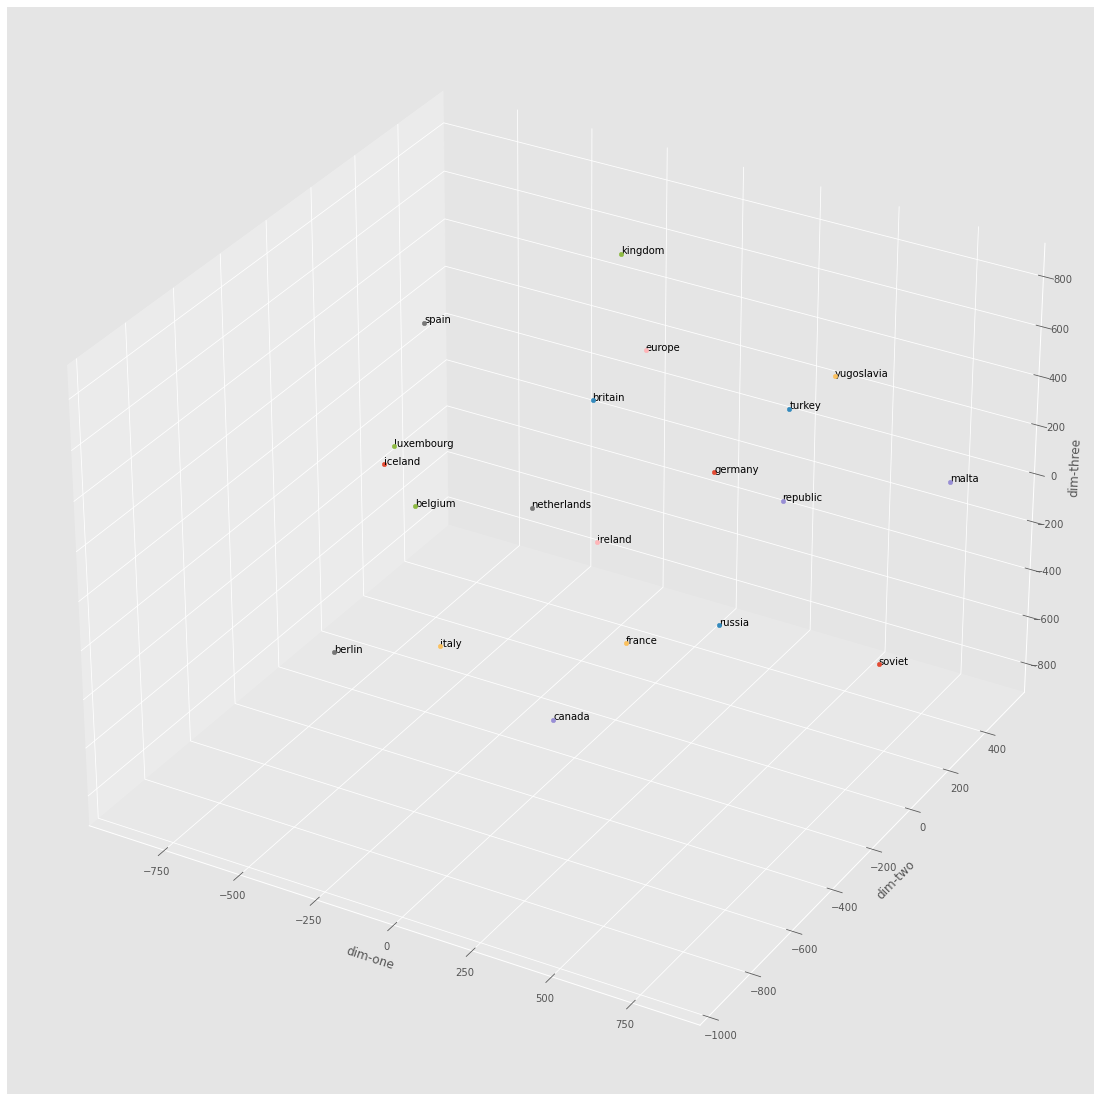

In [134]:
plot3D_with_labels(word='poland', k=20, model= my_best_rnn)

--- 
<div style="text-align: center"> <span style="color:green">GOOD LUCK WITH YOUR ASSIGNMENT 2!</span> </div>
<div style="text-align: center"> <span style="color:black">END OF ASSIGNMENT</span> </div>